<a href="https://colab.research.google.com/github/frogbysachs/LASA-Data-Science/blob/Unit-4/FrogSachU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ugly stuff

In [1]:
!pip install "preliz[full,notebook]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.2/514.2 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: nbclient
    Found existing installation: nbclient 0.10.0
    Uninstalling nbclient-0.10.0:
      Successfully uninstalled nbclient-0.10.0


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

#Guiding question
I'm going to be using the NBA player stats from the 2023-24 season for this project!

I want to model the number of 3 point shots made by different players depending on their position. The reason I'm picking this stat (3P) rather than the percent of the time a player makes their shot is because I know that different positions will get different raw numbers of opportunities for a 3pt shot, and to me that's more interesting than how often they make the shot.

In [3]:
#import Arrendondo's NBA stats spreadsheet
url = "https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv"
rawdata = pd.read_csv(url)

#I wanna see what it looks like!
rawdata

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


So for this analysis, I need to isolate the Pos and 3P columns (3P is currently hidden but it will show up in a sec!)

In [4]:
rawdata[['Pos','3P']]

,Pos,3P
0,PF-C,26
1,C,15
2,SG,62
3,PF,106
4,SG,131
...,...,...
567,PF,1
568,PG,175
569,C,5
570,C,1


In [5]:
#now I need to do some data wrangling to get my code to recognize my important categories

#identifies the different positions of NBA players
pos_encode = pd.Categorical(rawdata['Pos'])
pos_encode

['PF-C', 'C', 'SG', 'PF', 'SG', ..., 'PF', 'PG', 'C', 'C', 'C']
Length: 572
Categories (12, object): ['C', 'C-PF', 'PF', 'PF-C', ..., 'SF-PF', 'SF-SG', 'SG', 'SG-PG']

In [6]:
#Replaces all the NBA position names with a number, in pos_idx
pos_idx = pos_encode.codes
pos_idx

array([ 3,  0, 10,  2, 10, 10,  0,  7,  5,  2,  2,  2,  5,  7,  5,  7,  0,
        0,  0,  0,  5,  7,  5,  0,  2, 10,  5,  2,  2, 10, 10,  0,  7,  7,
        2,  2, 10, 10,  7, 10,  2,  5,  7,  0, 10,  0,  5,  7,  7, 10,  8,
        2,  0,  5,  7,  2, 10,  5,  5, 10,  7,  7,  7,  5,  5,  5,  7,  6,
       10,  2,  7, 10,  2,  0,  7,  5,  0, 10,  7, 10, 10,  2,  2, 10,  2,
        0,  5,  0, 10, 10,  0, 10,  7,  7, 10,  7,  2, 10,  0,  2,  7,  2,
        0,  5,  7,  7, 10,  8,  7,  2,  5,  5, 10,  5,  5,  0, 10, 10, 10,
        7,  0,  2, 10, 10,  2,  5, 10,  5,  7, 10,  5,  7,  0,  7, 10,  5,
        2,  0,  2, 10,  7, 10,  0,  0,  7,  5,  0,  2, 10,  5,  7,  5, 10,
       10,  5,  5,  7,  5, 10,  2,  1,  4,  5,  2,  0,  7,  5,  2,  2, 10,
        0,  5,  2,  5,  5,  0,  5,  2, 10,  5,  2,  2, 10, 10,  2, 10,  7,
        2, 10,  7, 10,  2,  2,  2,  5,  5,  5,  7,  5, 10,  2, 10, 10, 10,
        2, 10,  7,  0,  7, 10,  0,  5,  7,  5,  2, 10,  9,  2, 10, 10,  5,
        5, 10,  1,  0, 10

In [7]:
#stores the category names in a dictionary
#this dictionary format is required for pymc to properly read the categories
pos_coords = {"Pos": pos_encode.categories}
pos_coords

{'Pos': Index(['C', 'C-PF', 'PF', 'PF-C', 'PF-SF', 'PG', 'PG-SG', 'SF', 'SF-PF',
        'SF-SG', 'SG', 'SG-PG'],
       dtype='object')}

Ok, so now that I've wrangled my data into a nice usable dictionary variable, I can start my hierarchical model! First some prep work by guesstimating a likelihood:

<Axes: title={'center': '3-pointers'}, ylabel='Frequency'>

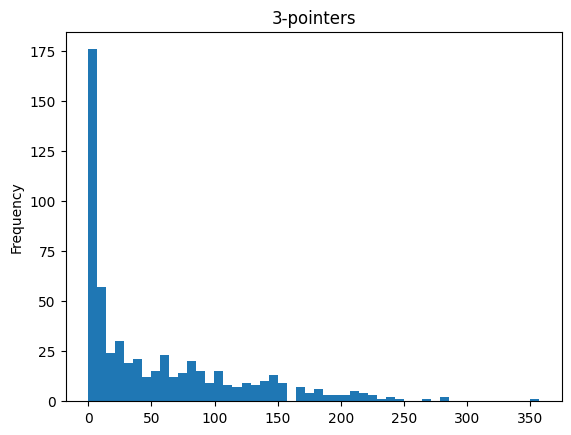

In [8]:
#to create a good likelihood, I want to see roughly what my 3-pointer data looks like in a histogram:
rawdata['3P'].plot(kind='hist', bins=50, title='3-pointers')

I'm thinking that an Exponential distribution might be good to model this histogram, with a mean of maybe 10-20? (I ultimately settled on mean = 15)

In [22]:
with pm.Model(coords = pos_coords) as nbamodel:
    # Hyper parameters
    # Using Normal and Halfnormal to guestimate what I kind of already know to be true based on looking at my histogram
    mu = pm.Normal('mu', mu = 15, sigma = 10)
    sigma = pm.HalfNormal('sigma', sigma = 10)


#since this is our only prior variable in likelihood, it will use hyperpriors
#Gamma for this since I want something Halfnormal-ish but not centered at 0
    inv_lambda = pm.Gamma('inv_lambda', mu = mu, sigma = sigma, dims = "Pos")

#Exponential - scale should be ~15, observed is kept
    likelihood = pm.Exponential('likelihood', scale = inv_lambda[pos_idx], observed = rawdata["3P"])



#target_accept has a default of 0.8. Increasing it makes us less likely to have divergences
    idata_nba = pm.sample(target_accept = 0.95)

Output()

Output()

Y'all that took me so incredibly long to get it to run properly. I'm honestly super proud that I got this to work and **SHOUTOUT DYLAN for telling me to use pos_idx instead of 'Pos'**.

My next step is going to be running a posterior predictive check to see what it looks like!

#Running checks on my hierarchical model!

Output()

<Axes: xlabel='likelihood'>

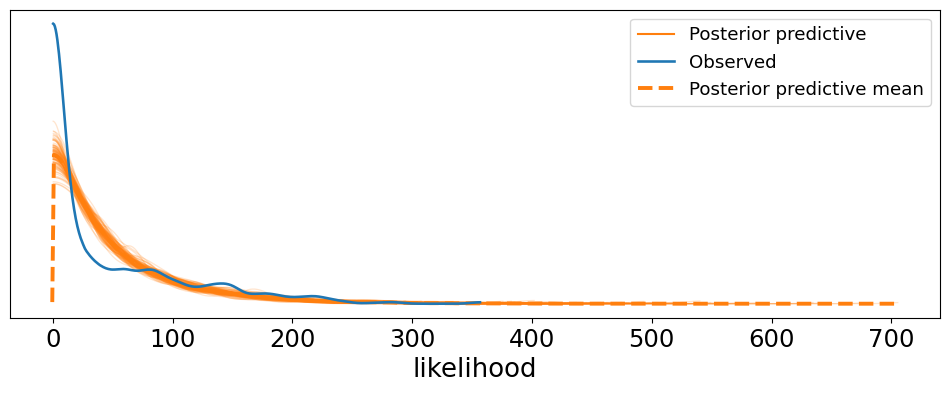

In [23]:
pm.sample_posterior_predictive(idata_nba, model=nbamodel, extend_inferencedata=True)
az.plot_ppc(idata_nba, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

In all honesty this isn't a fantastic model, but maybe it will be better if I compare it with an analogous nonhierarchical model, and maybe my positional mean graphs will turn out nice!

In [24]:
az.rhat(idata_nba)
#It looks like my rhat values for inv_lambda turned out pretty nice overall, nothing too garish. I'll be using these next!

<xarray.Dataset> Size: 352B
Dimensions:     (Pos: 12)
Coordinates:
  * Pos         (Pos) <U5 240B 'C' 'C-PF' 'PF' 'PF-C' ... 'SF-SG' 'SG' 'SG-PG'
Data variables:
    inv_lambda  (Pos) float64 96B 1.001 0.9997 1.001 1.002 ... 1.001 1.0 0.9996
    mu          float64 8B 1.0
    sigma       float64 8B 1.001

array([[<Axes: title={'center': 'inv_lambda'}>,
        <Axes: title={'center': 'inv_lambda'}>],
       [<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

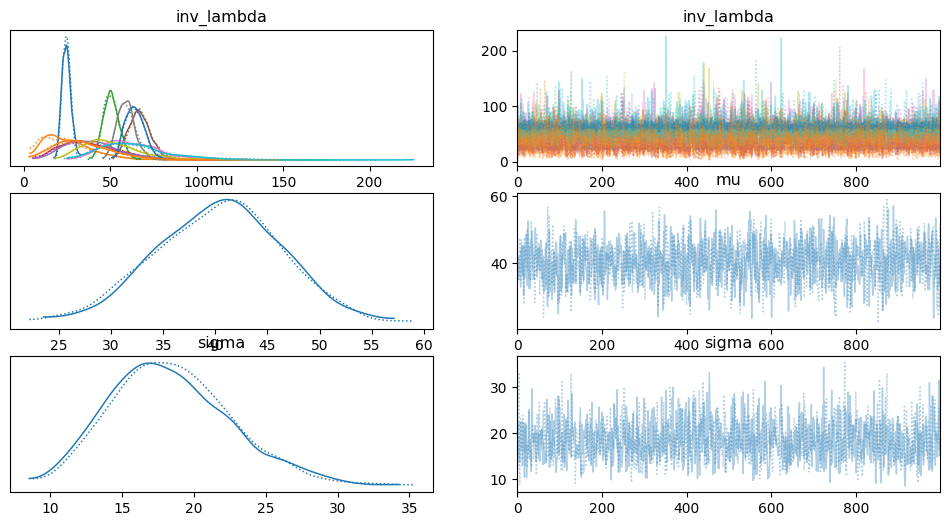

In [16]:
az.plot_trace(idata_nba)
#Honestly I did this just to track my chains but it's not that useful for my project

#Positional graphs & conclusions :)


I want to note before doing these means that technically, our NBA season stats spreadsheet gave us 12 different positions, but there are only 5 main ones: Center, Power Forward, Point Guard, Small Forward, and Shooting Guard.

The other seven "positions" are all designated for players who played some combination of the main 5 positions throughout the season, and since there's only a few of them I don't feel that it's that valuable to include them in my graphs if it means more than doubling the amount of work I have to do right now. So I'll just be graphing the big 5.

Text(0.5, 1.0, 'Shooting Guard mean')

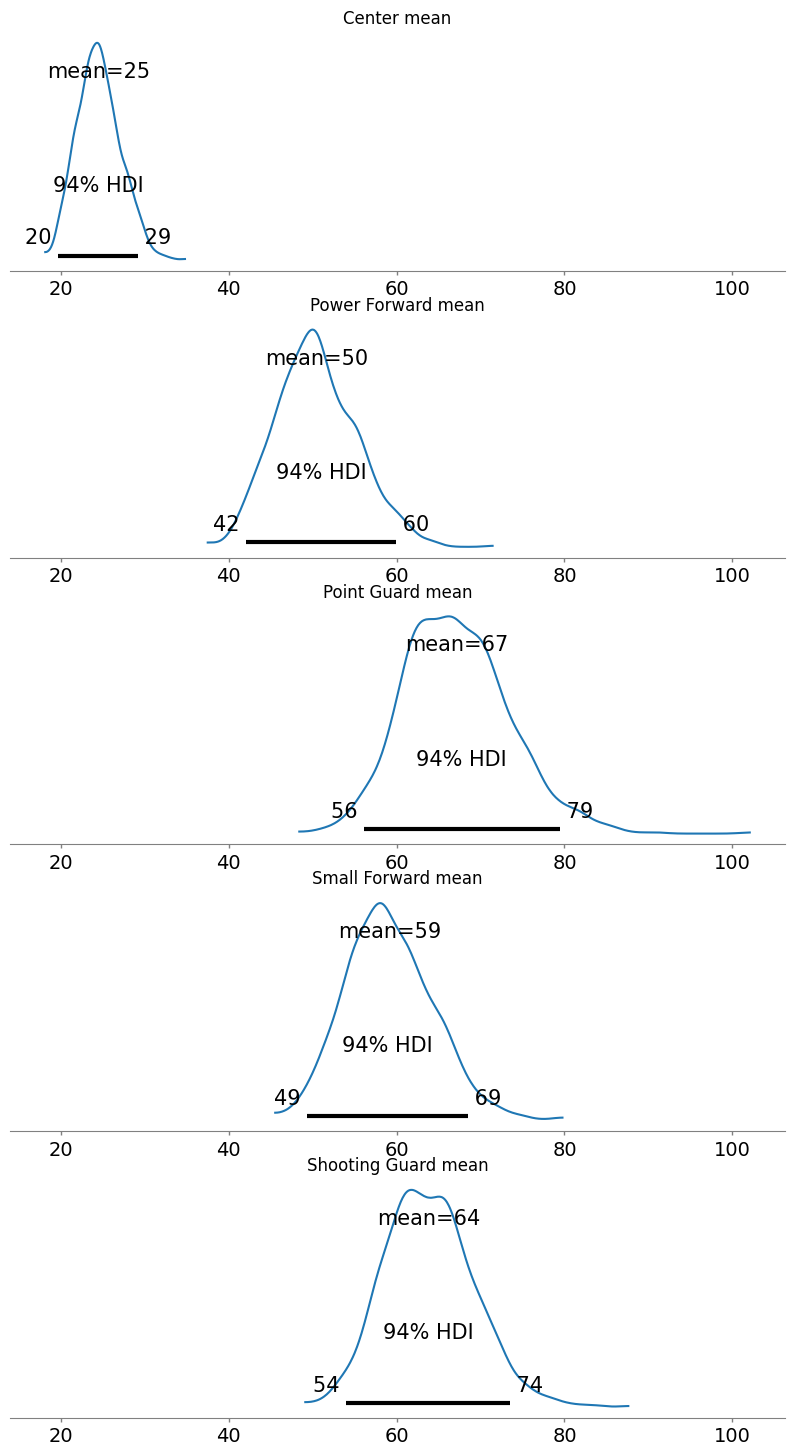

In [30]:
_, ax = plt.subplots(5, 1, figsize=(10, 18), sharex=True)

#plot the centers' 3P made
az.plot_posterior(idata_nba.posterior.sel(Pos="C"), var_names='inv_lambda', ax=ax[0])
ax[0].set_title(r"Center mean")

#plot the PFs' 3P made
az.plot_posterior(idata_nba.posterior.sel(Pos="PF"), var_names='inv_lambda', ax=ax[1])
ax[1].set_title(r"Power Forward mean")

#plot the PGs' 3P made
az.plot_posterior(idata_nba.posterior.sel(Pos="PG"), var_names='inv_lambda', ax=ax[2])
ax[2].set_title(r"Point Guard mean")

#plot the SFs' 3P made
az.plot_posterior(idata_nba.posterior.sel(Pos="SF"), var_names='inv_lambda', ax=ax[3])
ax[3].set_title(r"Small Forward mean")

#plot the SGs' 3P made
az.plot_posterior(idata_nba.posterior.sel(Pos="SG"), var_names='inv_lambda', ax=ax[4])
ax[4].set_title(r"Shooting Guard mean")

So now for some commentary on these graphs.

It's interesting to me that the computer is so much more confident of the true number of shots made for centers- I think this is because centers pretty consistently shoot 3-pointers less than the guards, so maybe NBA centers' number of shots made is more similar to one another.

As for other positions, it seems that my code is 94% confident that the true inv_lambda value lies within a roughly 20% variance of the expected mean. That's numerically not great, but given how much variation there is in how much play time different NBA players get, I'm gonna say that it's actually pretty good considering that context.

**Quick note on what inv_lambda actually is / means because I forgot too**- inv_lambda is my scale variable for my likelihood (Exponential function), meaning that it is a stand-in for what I expect the "mean" to look like for each of those positions. So when I'm graphing inv_lambda posteriors, that's the _mean number of shots made by position_.

#Parking Lot
This is just code that didn't turn out to be useful but I didn't want to delete it. A parking lot will probably stay at the bottom of all my projects from here on out.

    # Parameters for positions
    #mu_p uses both hyperparameters from prev lines
    mu_p = pm.Beta('mu_p', mu = mu, nu = nu, dims = "Pos")
    mu_p = pm.Halfnormal('mu_p', sigma = )
    # don't say the mean is somewhere between 0 and 1, try a halfnormal for this

    likelihood = pm.Normal('likelihood', mu = mu_p['Pos'], sigma = Sigma['Pos'], observed = rawdata["3P"])
